In [1]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.svm import SVC
import graphviz
import os
import statsmodels.discrete.discrete_model as sm
import scikitplot as skplt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('train.csv', index_col = 0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Before we begin feature engineering, we split the train data into training data and test data:

In [3]:
y = df['Survived']

In [4]:
X = df[['Pclass', 'Age', 'Sex', "Embarked"]]

In [5]:
y.shape

(891,)

In [6]:
X.shape

(891, 4)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=42)

In [8]:
y_train.value_counts()

0    412
1    256
Name: Survived, dtype: int64

In [9]:
y_test.value_counts()

0    137
1     86
Name: Survived, dtype: int64

In [10]:
X_train.head()

,Pclass,Age,Sex,Embarked
PassengerId,,,,
487,1,35.0,female,S
239,2,19.0,male,S
723,2,34.0,male,S
185,3,4.0,female,S
57,2,21.0,female,S


In [11]:
y_train.head()

PassengerId
487    1
239    0
723    0
185    1
57     1
Name: Survived, dtype: int64

### Feature engineering: 
* *scale* the Pclass (primarily to aid the SVM we run later)
* *one-hot-encode* the category of sex (turn it from category to binary)
* *impute* to populate the missing age values with the overall mean age
* also add missing values to embarkation point for two passengers
* create a new binary column indicating whether the passenger embarked at Cherbourg (C)
* *bin* the ages to convert from scalar to category and *one-hot-encode* to assign a 1 or 0 to each age bracket

(as a function so that we can later call it on the test data):

In [12]:
scaler = MinMaxScaler()
X_train['Pclass'] = scaler.fit_transform(X_train.copy()[['Pclass']])

C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Dave\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
X_train.head()

,Pclass,Age,Sex,Embarked
PassengerId,,,,
487,0.0,35.0,female,S
239,0.5,19.0,male,S
723,0.5,34.0,male,S
185,1.0,4.0,female,S
57,0.5,21.0,female,S


In [14]:
def cleaning(dataframe):
    dataframe['Sex'] = pd.get_dummies(dataframe['Sex'], drop_first = True) #one-hot-encode to turn sex from category to binary
    dataframe['Age'].fillna(np.mean(dataframe['Age']), inplace=True) # impute to fill in the missing age values
    dataframe['Embarked'].fillna('S', inplace=True)
    dataframe['age_grp']= pd.cut(dataframe['Age'], bins = [0,12,25,45,80],duplicates='drop').astype(str)
    dummies1 = pd.get_dummies(dataframe['age_grp'], drop_first=True )
    dataframe = pd.merge(dummies1, dataframe, right_index=True, left_index=True)
    del dataframe['age_grp']
    del dataframe['Age']
    dummies2 = pd.get_dummies(dataframe['Embarked'])
    dataframe = pd.merge(dummies2, dataframe, right_index=True, left_index=True)
    del dataframe['Embarked']
    del dataframe ['Q']
    del dataframe['S']
    return dataframe

In [15]:
cXtr = cleaning(X_train.copy())

In [16]:
cXtr.head()

,C,"(12, 25]","(25, 45]","(45, 80]",Pclass,Sex
PassengerId,,,,,,
487,0,0,1,0,0.0,0
239,0,1,0,0,0.5,1
723,0,0,1,0,0.5,1
185,0,0,0,0,1.0,0
57,0,1,0,0,0.5,0


### Next, we define, fit and examine model:

In [17]:
m = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)

In [18]:
m.fit(cXtr, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
m.score(cXtr, y_train) # Calculate the accuracy of the model

0.7949101796407185

In [20]:
m.coef_

array([[ 0.42215547, -1.00422768, -0.96936696, -1.54045619, -1.94839249,
        -2.50382571]])

so boarding at Cherbourg has a positive influence, Pclass has a negative influence, age a smaller negative influence and sex (in this case, "maleness") a stronger negative influence on chance of survival.

In [21]:
m.intercept_

array([3.15790671])

(Interpretation of the intercept goes here)

In [22]:
Dave = [[0, 0, 1, 0, 0.5, 1]] # create a new input value called Dave

In [23]:
m.predict_proba(Dave) # predict probability of Dave first dying and then surviving (as survived = 0 --> "died")

array([[0.78405953, 0.21594047]])

so Dave has around a (xx)% chance of survival based on the input values we used

In [24]:
ypredtr = m.predict(cXtr)

In [25]:
ypredtr

array([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,

In [26]:
confusion_matrix(y_pred = ypredtr, y_true = y_train)

array([[344,  68],
       [ 69, 187]], dtype=int64)

In [27]:
precision_score(y_pred = ypredtr, y_true = y_train)

0.7333333333333333

In [28]:
recall_score(y_pred = ypredtr, y_true = y_train)

0.73046875

In [29]:
yprobtr = m.predict_proba(cXtr)

In [30]:
yprobtr

array([[0.10078436, 0.89921564],
       [0.78990335, 0.21009665],
       [0.78405953, 0.21594047],
       ...,
       [0.58198855, 0.41801145],
       [0.70814157, 0.29185843],
       [0.9058239 , 0.0941761 ]])

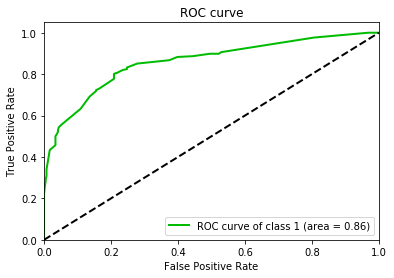

In [31]:
skplt.metrics.plot_roc(y_train, yprobtr, title = 'ROC curve', plot_micro = False, plot_macro = False, classes_to_plot = 1)

---Validate your model---

In [32]:
cross_val_score(m, cXtr, y_train, cv=5, scoring = 'accuracy')

array([0.77037037, 0.75373134, 0.84210526, 0.81954887, 0.78947368])

This produces a wider range of scores than we would like. Let's try bootstrapping:

In [33]:
boots = []

for i in range(1000):
    Xb, yb = resample(cXtr, y_train)
    m.fit(Xb, yb)
    score = m.score(Xb, yb)
    boots.append(score)
    print(i, score)

0 0.7859281437125748
1 0.811377245508982
2 0.8158682634730539
3 0.8098802395209581
4 0.8248502994011976
5 0.7934131736526946
6 0.811377245508982
7 0.811377245508982
8 0.8068862275449101
9 0.812874251497006
10 0.8083832335329342
11 0.8218562874251497
12 0.811377245508982
13 0.8263473053892215
14 0.7859281437125748
15 0.7829341317365269
16 0.7874251497005988
17 0.8053892215568862
18 0.8008982035928144
19 0.7724550898203593
20 0.8068862275449101
21 0.812874251497006
22 0.7904191616766467
23 0.7964071856287425
24 0.8248502994011976
25 0.7844311377245509
26 0.7859281437125748
27 0.7829341317365269
28 0.7994011976047904
29 0.8173652694610778
30 0.7724550898203593
31 0.812874251497006
32 0.811377245508982
33 0.8038922155688623
34 0.8023952095808383
35 0.7859281437125748
36 0.8098802395209581
37 0.7934131736526946
38 0.8188622754491018
39 0.8068862275449101
40 0.7619760479041916
41 0.8158682634730539
42 0.7979041916167665
43 0.812874251497006
44 0.7964071856287425
45 0.7889221556886228
46 0.78

371 0.7949101796407185
372 0.812874251497006
373 0.7904191616766467
374 0.8068862275449101
375 0.8098802395209581
376 0.8173652694610778
377 0.7754491017964071
378 0.8143712574850299
379 0.7844311377245509
380 0.8218562874251497
381 0.7979041916167665
382 0.8008982035928144
383 0.8218562874251497
384 0.8053892215568862
385 0.7889221556886228
386 0.8173652694610778
387 0.8098802395209581
388 0.7949101796407185
389 0.8218562874251497
390 0.7904191616766467
391 0.7919161676646707
392 0.7934131736526946
393 0.7739520958083832
394 0.8263473053892215
395 0.8233532934131736
396 0.8338323353293413
397 0.7709580838323353
398 0.8293413173652695
399 0.7964071856287425
400 0.7874251497005988
401 0.7979041916167665
402 0.8083832335329342
403 0.7904191616766467
404 0.8143712574850299
405 0.8008982035928144
406 0.8173652694610778
407 0.8143712574850299
408 0.8068862275449101
409 0.8023952095808383
410 0.8053892215568862
411 0.8008982035928144
412 0.7874251497005988
413 0.7949101796407185
414 0.784431

759 0.8083832335329342
760 0.8203592814371258
761 0.812874251497006
762 0.8053892215568862
763 0.8233532934131736
764 0.8068862275449101
765 0.7994011976047904
766 0.7964071856287425
767 0.7859281437125748
768 0.8158682634730539
769 0.8098802395209581
770 0.8098802395209581
771 0.7694610778443114
772 0.7949101796407185
773 0.8173652694610778
774 0.7634730538922155
775 0.8143712574850299
776 0.8053892215568862
777 0.781437125748503
778 0.8068862275449101
779 0.8143712574850299
780 0.7964071856287425
781 0.8203592814371258
782 0.8023952095808383
783 0.8023952095808383
784 0.7934131736526946
785 0.8278443113772455
786 0.8248502994011976
787 0.7904191616766467
788 0.8098802395209581
789 0.8008982035928144
790 0.7829341317365269
791 0.8068862275449101
792 0.7739520958083832
793 0.8188622754491018
794 0.7874251497005988
795 0.781437125748503
796 0.8038922155688623
797 0.7844311377245509
798 0.8158682634730539
799 0.8173652694610778
800 0.7964071856287425
801 0.7829341317365269
802 0.79341317

In [34]:
boots.sort()

In [35]:
ci80 = boots[100:-100]
print(f"80% confidence interval: {ci80[0]:5.4} -{ci80[-1]:5.4}")

80% confidence interval: 0.7814 -0.8219


In [36]:
ci90 = boots[50:-50]
print(f"90% confidence interval: {ci90[0]:5.4} -{ci90[-1]:5.4}")

90% confidence interval: 0.774 -0.8263


In [37]:
ci95 = boots[25:-25]
print(f"95% confidence interval: {ci95[0]:5.4} -{ci95[-1]:5.4}")

95% confidence interval: 0.7695 -0.8308


In [38]:
ci99 = boots[5:-5]
print(f"99% confidence interval: {ci99[0]:5.4} -{ci99[-1]:5.4}")

99% confidence interval: 0.759 -0.8383


### Let's test the same model on the X_test sample. First we clean it using the function:

In [39]:
X_test['Pclass'] = scaler.fit_transform(X_test[['Pclass']])

C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Dave\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [40]:
X_test.head()

,Pclass,Age,Sex,Embarked
PassengerId,,,,
158,1.0,30.0,male,S
502,1.0,21.0,female,Q
353,1.0,15.0,male,C
83,1.0,NaN,female,Q
684,1.0,14.0,male,S


In [41]:
cXte = cleaning(X_test.copy())


In [42]:
cXtr.head(10)

,C,"(12, 25]","(25, 45]","(45, 80]",Pclass,Sex
PassengerId,,,,,,
487,0,0,1,0,0.0,0
239,0,1,0,0,0.5,1
723,0,0,1,0,0.5,1
185,0,0,0,0,1.0,0
57,0,1,0,0,0.5,0
749,0,1,0,0,0.0,1
639,0,0,1,0,1.0,0
254,0,0,1,0,1.0,1
141,1,0,1,0,1.0,0


In [43]:
cXte.head(10)

,C,"(12, 25]","(25, 45]","(45, 80]",Pclass,Sex
PassengerId,,,,,,
158,0,0,1,0,1.0,1
502,0,1,0,0,1.0,0
353,1,1,0,0,1.0,1
83,0,0,1,0,1.0,0
684,0,1,0,0,1.0,1
85,0,1,0,0,0.5,0
780,0,0,1,0,0.0,0
516,0,0,0,1,0.0,1
729,0,1,0,0,0.5,1


### Then check our scores again on this test data:

In [44]:
cross_val_score(m, cXte, y_test, cv=5, scoring = 'accuracy')

array([0.7173913 , 0.8       , 0.65909091, 0.70454545, 0.77272727])

In [45]:
boots = []

for i in range(1000):
    Xb, yb = resample(cXte, y_test)
    m.fit(Xb, yb)
    score = m.score(Xb, yb)
    boots.append(score)
    print(i, score)

0 0.8251121076233184
1 0.7802690582959642
2 0.7802690582959642
3 0.7847533632286996
4 0.7847533632286996
5 0.7757847533632287
6 0.8295964125560538
7 0.8161434977578476
8 0.8161434977578476
9 0.7623318385650224
10 0.8609865470852018
11 0.8251121076233184
12 0.7713004484304933
13 0.7802690582959642
14 0.7982062780269058
15 0.8654708520179372
16 0.820627802690583
17 0.7488789237668162
18 0.7847533632286996
19 0.7937219730941704
20 0.7443946188340808
21 0.7713004484304933
22 0.7982062780269058
23 0.7668161434977578
24 0.7937219730941704
25 0.7623318385650224
26 0.7847533632286996
27 0.7982062780269058
28 0.7668161434977578
29 0.7802690582959642
30 0.8026905829596412
31 0.7399103139013453
32 0.7847533632286996
33 0.7982062780269058
34 0.757847533632287
35 0.7668161434977578
36 0.7847533632286996
37 0.820627802690583
38 0.8161434977578476
39 0.7937219730941704
40 0.8251121076233184
41 0.8385650224215246
42 0.7713004484304933
43 0.7757847533632287
44 0.7847533632286996
45 0.7668161434977578
4

373 0.7937219730941704
374 0.820627802690583
375 0.7982062780269058
376 0.7668161434977578
377 0.8026905829596412
378 0.8026905829596412
379 0.7757847533632287
380 0.757847533632287
381 0.7713004484304933
382 0.7668161434977578
383 0.7982062780269058
384 0.8295964125560538
385 0.7892376681614349
386 0.7219730941704036
387 0.7892376681614349
388 0.7937219730941704
389 0.726457399103139
390 0.8026905829596412
391 0.7937219730941704
392 0.7802690582959642
393 0.7713004484304933
394 0.7802690582959642
395 0.7982062780269058
396 0.7982062780269058
397 0.7713004484304933
398 0.7937219730941704
399 0.8026905829596412
400 0.7982062780269058
401 0.7937219730941704
402 0.7757847533632287
403 0.7713004484304933
404 0.7219730941704036
405 0.820627802690583
406 0.8116591928251121
407 0.726457399103139
408 0.7713004484304933
409 0.7802690582959642
410 0.7982062780269058
411 0.8026905829596412
412 0.8161434977578476
413 0.7847533632286996
414 0.7623318385650224
415 0.8026905829596412
416 0.7623318385

750 0.8071748878923767
751 0.7757847533632287
752 0.820627802690583
753 0.7668161434977578
754 0.852017937219731
755 0.7937219730941704
756 0.8071748878923767
757 0.7892376681614349
758 0.7354260089686099
759 0.8161434977578476
760 0.7892376681614349
761 0.7937219730941704
762 0.7802690582959642
763 0.8385650224215246
764 0.7399103139013453
765 0.7937219730941704
766 0.7668161434977578
767 0.7802690582959642
768 0.7982062780269058
769 0.7937219730941704
770 0.8116591928251121
771 0.7802690582959642
772 0.8116591928251121
773 0.8565022421524664
774 0.8251121076233184
775 0.820627802690583
776 0.8071748878923767
777 0.7533632286995515
778 0.8116591928251121
779 0.7982062780269058
780 0.757847533632287
781 0.7802690582959642
782 0.7713004484304933
783 0.820627802690583
784 0.8071748878923767
785 0.7982062780269058
786 0.726457399103139
787 0.8475336322869955
788 0.8026905829596412
789 0.8026905829596412
790 0.7713004484304933
791 0.8295964125560538
792 0.7982062780269058
793 0.82959641255

In [46]:
boots.sort()

In [47]:
ci80 = boots[100:-100]
print(f"80% confidence interval: {ci80[0]:5.4} -{ci80[-1]:5.4}")

80% confidence interval: 0.7534 -0.8206


In [48]:
ci90 = boots[50:-50]
print(f"90% confidence interval: {ci90[0]:5.4} -{ci90[-1]:5.4}")

90% confidence interval: 0.7399 -0.8341


In [49]:
ci95 = boots[25:-25]
print(f"95% confidence interval: {ci95[0]:5.4} -{ci95[-1]:5.4}")

95% confidence interval: 0.7265 -0.8386


In [50]:
ci99 = boots[5:-5]
print(f"99% confidence interval: {ci99[0]:5.4} -{ci99[-1]:5.4}")

99% confidence interval: 0.713 -0.8655


### Tune the hyperparameters for our Logistic Regression model: we do a Grid Search selecting different C-values (levels of regularisation)

In [51]:
params = {
    'C': [20.0, 15.0, 10.0, 5.0, 1.0, 0.1, 0.01, 0.001]
}
g = GridSearchCV(m, param_grid=params, cv=5, iid=False)
g.fit(cXtr, y_train)
g.score(cXtr, y_train)

0.8038922155688623

In [52]:
g.best_params_

{'C': 20.0}

Check score for Logistic Regression model on test data:

In [53]:
m.score(cXte, y_test)

0.7668161434977578

In [54]:
m.coef_

array([[ 0.3843867 ,  0.23391275, -0.26526994, -0.505036  , -1.20319103,
        -2.95398617]])

# Next we will apply a random forest to our data set:

First, a decision tree:

In [55]:
t = DecisionTreeClassifier(max_depth=5)

In [56]:
t.fit(cXtr, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [57]:
t.score(cXtr, y_train)

0.8098802395209581

We visualise this using graphviz:

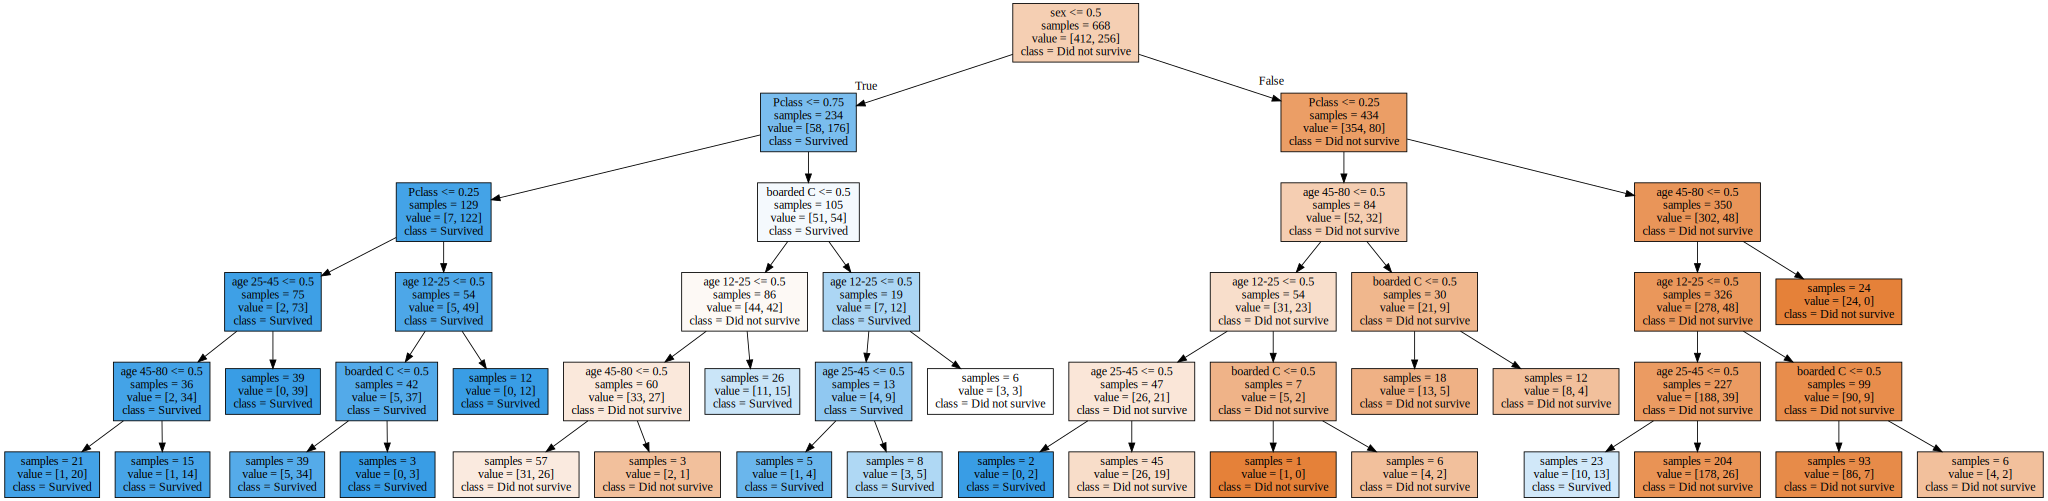

In [58]:
tree = export_graphviz(t, out_file=None, 
                class_names=["Did not survive", "Survived"],
                feature_names=['boarded C','age 12-25', 'age 25-45', 'age 45-80', "Pclass", "sex"],
                impurity=False,
                filled=True)
open('titanic.dot', 'w').write(tree)

graph = graphviz.Source(tree)
graph.render('tree')  # creates PDF
graph # displays in jupyter

Then expand this to a Random Forest:

In [59]:
rf = RandomForestClassifier()
rf.fit(cXtr, y_train)
rf.score(cXtr, y_train)

C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8188622754491018

### To tune the hyperparameters for our Random Forest, we do a Grid Search, selecting different levels of maximum tree depth and different numbers of trees:

In [60]:
params = {
    'max_depth': [1, 2, 4, 6],
    'n_estimators': [1, 3, 5, 7, 10, 15, 20]
}
g = GridSearchCV(rf, param_grid=params, cv=5, iid=False)
g.fit(cXtr, y_train)
g.score(cXtr, y_train)

0.781437125748503

In [61]:
g.best_params_

{'max_depth': 2, 'n_estimators': 15}

Decision tree for test data:

In [62]:
t.score(cXte, y_test)

0.7623318385650224

In [63]:
rf.score(cXte, y_test)

0.7802690582959642

In [64]:
g.score(cXte, y_test)

0.8071748878923767

In [65]:
# m_poly = PolynomialFeatures(2)
# n = m_poly.fit_transform(X_train)

## Now let's try a Support Vector:

In [66]:
sv = SVC()

In [67]:
sv.fit(cXtr, y_train)

C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [68]:
sv.score(cXtr, y_train)

0.7934131736526946

In [69]:
sv.score(cXte, y_test)

0.7668161434977578